<h2 align="center" style="color:blue">Error Analysis</h2>

In [1]:
# Import necessary libraries
from imports import *

In [2]:
# Load Best Model (XGBoost) and Test datasets(X_test, y_test)

best_model = load("../outputs/models/xgb_best_model.pkl")

X_test = pd.read_parquet("../data/processed/overall_X_test.parquet")
y_test = pd.read_parquet("../data/processed/overall_y_test.parquet").squeeze()  # convert to Series

In [3]:
X = pd.read_parquet("../data/processed/overall_final_features.parquet")
print(X.shape)

(49908, 15)


In [4]:
# Generate predictions using the tuned model
y_pred = best_model.predict(X_test)

# Calculate raw residuals and percentage error
# diff_pct shows how far off the model is relative to actual premium
residuals = y_pred - y_test
residuals_pct = residuals*100/y_test

# Combine results into a single dataframe for easier analysis
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct
})

results_df.head()

,actual,predicted,diff,diff_pct
0,20554,20469.792969,-84.207031,-0.409687
1,29647,29161.392578,-485.607422,-1.637965
2,20560,20657.236328,97.236328,0.472939
3,5018,7410.395508,2392.395508,47.676276
4,8929,8409.642578,-519.357422,-5.816524


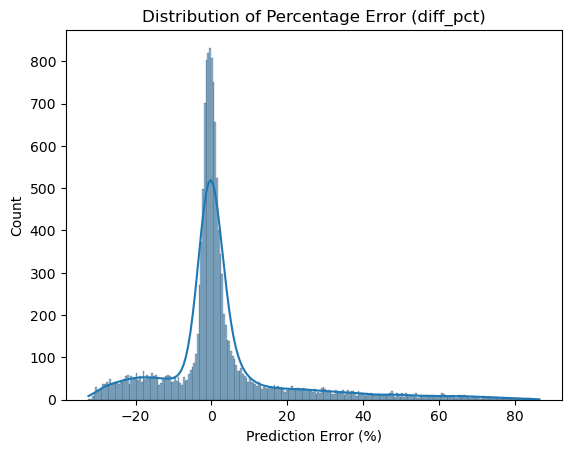

In [5]:
# Plot the distribution of percentage errors
# This reveals whether the model is consistently accurate or has dangerous outliers
sns.histplot(results_df['diff_pct'], kde=True)
plt.title("Distribution of Percentage Error (diff_pct)")
plt.xlabel("Prediction Error (%)")
plt.ylabel("Count")
plt.savefig('../outputs/figures/overall/distribution_percentage_error.png', dpi=300)
plt.show()

In [6]:
# Set an error threshold (e.g., 10% is still acceptable in pricing applications)
extreme_error_threshold = 10

# Identify all predictions where the model is off by more than 10%
extreme_results_df = results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]
extreme_results_df.shape

(4473, 4)

In [7]:
results_df.shape

(14973, 4)

In [8]:
# Compute percentage of extreme errors
extreme_error_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

29.873772791023843

In [9]:
results_df[np.abs(results_df.diff_pct)>50].sort_values('diff_pct', ascending=False)

,actual,predicted,diff,diff_pct
13342,3501,6529.951660,3028.951660,86.516757
4181,3523,6537.590332,3014.590332,85.568843
8251,3521,6529.951660,3008.951660,85.457304
10990,3516,6499.706055,2983.706055,84.860809
9102,3536,6524.146973,2988.146973,84.506419
...,...,...,...,...
13755,4536,6814.676758,2278.676758,50.235378
9104,4739,7117.190430,2378.190430,50.183381
7929,5381,8080.514160,2699.514160,50.167518
79,4349,6529.951660,2180.951660,50.148348


In [10]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,bmi_category,income_lakhs,insurance_plan,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
3,0.092593,0.2,0.666667,0.131313,0.0,0.428571,1,0,0,0,1,0,0,0,0
6,0.018519,0.2,0.000000,0.030303,0.0,0.000000,0,1,0,0,1,0,0,1,0
7,0.000000,0.2,0.666667,0.020202,0.0,0.000000,1,0,0,1,1,0,0,0,0
13,0.055556,0.0,0.000000,0.242424,0.0,0.000000,0,0,0,0,1,0,0,0,0
15,0.111111,0.2,0.000000,0.070707,0.5,0.000000,1,0,0,0,1,0,0,0,0


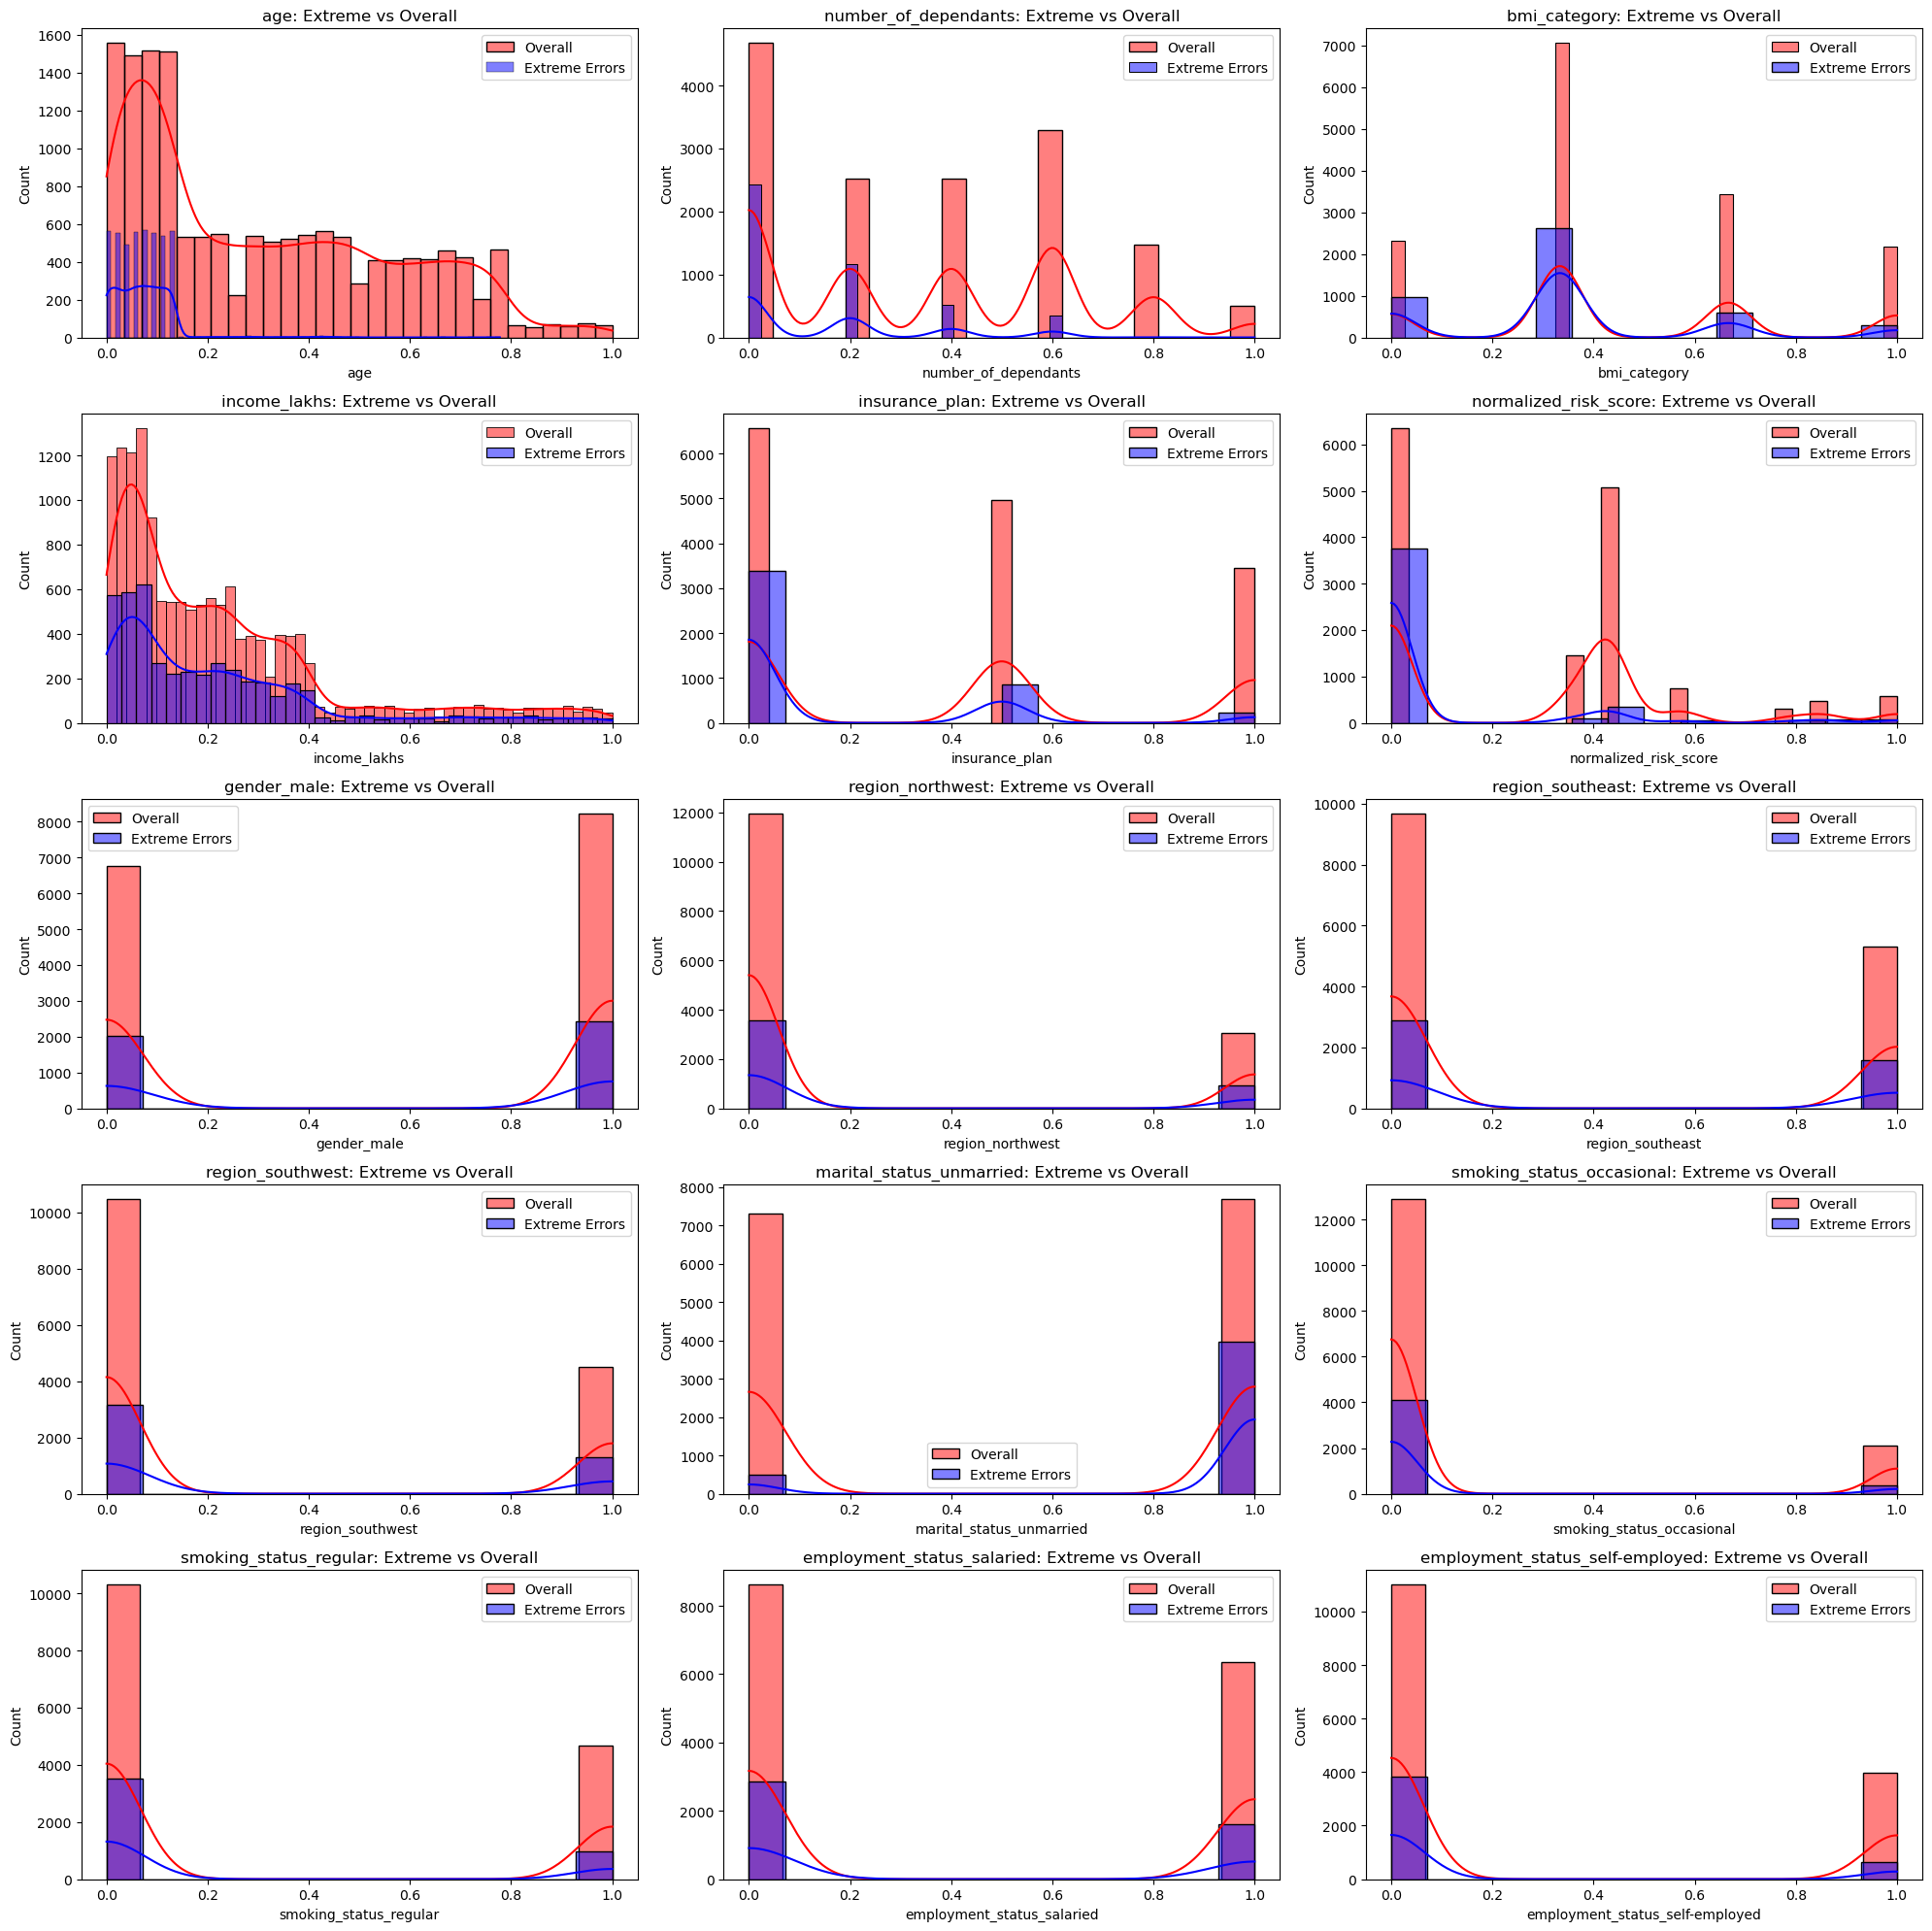

In [11]:
# Create a multi-panel figure to compare feature distributions
# for extreme-error rows vs overall test data

features = X_test.columns
n_feats = len(features)

rows = math.ceil(n_feats / 3)   # 3 plots per row
cols = 3

plt.figure(figsize=(20, rows * 4))

for i, feature in enumerate(features, 1):
    plt.subplot(rows, cols, i)
    
    # Distribution for entire test dataset
    sns.histplot(X_test[feature], label='Overall', alpha=0.5, color='red', kde=True)
    
    # Distribution for extreme error subset
    sns.histplot(extreme_errors_df[feature], label='Extreme Errors', color='blue', kde=True)
    
    plt.title(f'{feature}: Extreme vs Overall')
    plt.legend()

plt.tight_layout()
plt.savefig("../outputs/figures/overall/extreme_vs_overall_distributions.png", dpi=300)
plt.show()

In [12]:
from joblib import load

scaler = load("../outputs/models/minmax_scaler.pkl")

In [13]:
cols_to_scale = load("../outputs/models/cols_to_scale.pkl")

print(cols_to_scale)

['age', 'number_of_dependants', 'bmi_category', 'income_level', 'income_lakhs', 'insurance_plan']


In [14]:
extreme_errors_df.columns

Index(['age', 'number_of_dependants', 'bmi_category', 'income_lakhs',
       'insurance_plan', 'normalized_risk_score', 'gender_male',
       'region_northwest', 'region_southeast', 'region_southwest',
       'marital_status_unmarried', 'smoking_status_occasional',
       'smoking_status_regular', 'employment_status_salaried',
       'employment_status_self-employed'],
      dtype='object')

In [15]:
extreme_errors_df['income_level']=-1

In [16]:
df_reversed = pd.DataFrame()

# Apply inverse scaling to the selected columns only
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])

# Display reversed-scale values for verification
df_reversed

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan
0,23.0,1.0,3.0,-2.0,14.0,1.0
1,19.0,1.0,1.0,-2.0,4.0,1.0
2,18.0,1.0,3.0,-2.0,3.0,1.0
3,21.0,0.0,1.0,-2.0,25.0,1.0
4,24.0,1.0,1.0,-2.0,8.0,2.0
...,...,...,...,...,...,...
4468,19.0,1.0,2.0,-2.0,8.0,1.0
4469,25.0,0.0,2.0,-2.0,12.0,1.0
4470,21.0,0.0,2.0,-2.0,7.0,2.0
4471,21.0,1.0,2.0,-2.0,8.0,1.0


<Axes: xlabel='age', ylabel='Count'>

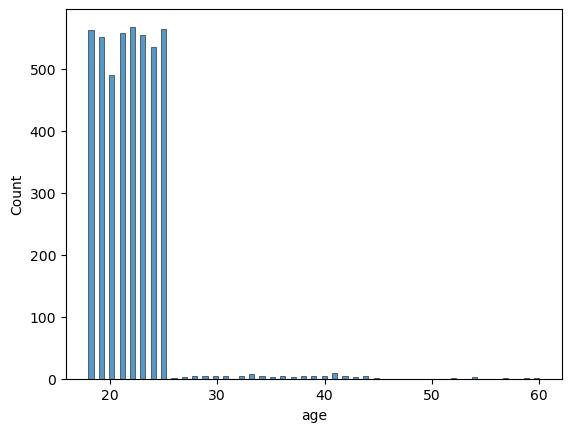

In [17]:
# Examine the distribution of true ages for extreme-error cases
sns.histplot(df_reversed['age'])

In [18]:
df_reversed['age'].quantile(0.97)

25.0

After reverse-scaling the extreme-error subset, we discovered a critical pattern:

**97% of all predictions with more than ±50% error are for customers aged 25 or younger.**

This indicates a strong segmentation issue in the model. The model performs well for middle-aged and older customers but consistently fails for younger policyholders.